In [ ]:
!pip install ipynbname
!pip install gdown --upgrade
import ipynbname

nb_path = ipynbname.path()  # returns a pathlib.Path object
print("Notebook name:", nb_path.name)

Notebook name: fileId=1hTaCTJTZyd8XK00ajAc0_-7zcWUGlHHI


In [1]:
!pip install rasterio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 15.5 MB/s eta 0:00:00


In [63]:
import numpy as np
import pandas as pd
from IPython.display import display
import os
import rasterio
from IPython.display import display
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, jaccard_score, cohen_kappa_score
from sklearn.model_selection import train_test_split

In [64]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [65]:
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")

2.6.0+cu124
CUDA available: False
GPU name: N/A


In [5]:
from google.colab import files
uploaded = files.upload()


Saving all_DATA.zip to all_DATA.zip


In [6]:
import zipfile
import os

zip_path = "/content/all_DATA.zip"
extract_path = "/content"

# Unzip it
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Confirm it worked
print("Extracted files:", os.listdir(extract_path))


Extracted files: ['.config', 'all_DATA', 'all_DATA.zip', 'sample_data']


In [112]:
state = "WB"
data_dir = f"/content/all_DATA/{state}/GEE_Patches"
results_path = f"rf_{state}.csv"

In [113]:
# Set hyperparameters

PATCH_SIZE = 50
BATCH_SIZE = 32
EPOCHS = 50

DIFFUSION_STEPS = 100
MIN_BETA = 1e-4
MAX_BETA = 0.02
betas = np.linspace(MIN_BETA, MAX_BETA, DIFFUSION_STEPS, dtype=np.float32)
alphas = 1.0 - betas
alpha_bars = np.cumprod(alphas).astype(np.float32)




In [114]:
## Image patch extraction

def extract_patches(image, patch_size=PATCH_SIZE):
    patches = []
    h, w = image.shape
    for i in range(h // patch_size):
        for j in range(w // patch_size):
            patch = image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            patches.append(patch)
    return np.expand_dims(np.array(patches), axis=-1)

def load_and_extract_patches(directory):
    vh_files = sorted([f for f in os.listdir(directory) if f.startswith('S1_VH')])
    ndwi_files = sorted([f for f in os.listdir(directory) if f.startswith('S2_NDWI')])
    mask_files = sorted([f for f in os.listdir(directory) if f.startswith('Mask')])

    print("First 3 VH files:")
    for file in vh_files[:3]:
        print(file)

    print("First 3 NDWI files:")
    for file in ndwi_files[:3]:
        print(file)

    print("First 3 Mask files:")
    for file in mask_files[:3]:
        print(file)

    X_vh, X_ndwi, y = [], [], []
    for vh_file, ndwi_file, mask_file in zip(vh_files, ndwi_files, mask_files):
        with rasterio.open(os.path.join(directory, vh_file)) as src: vh_img = np.nan_to_num(src.read(1))
        with rasterio.open(os.path.join(directory, ndwi_file)) as src: ndwi_img = np.nan_to_num(src.read(1))
        with rasterio.open(os.path.join(directory, mask_file)) as src:
            mask_img = (np.nan_to_num(src.read(1)) > 0).astype(np.float32)

        X_vh.append(extract_patches(vh_img))
        X_ndwi.append(extract_patches(ndwi_img))
        y.append(extract_patches(mask_img))

    X_vh = np.concatenate(X_vh)
    X_ndwi = np.concatenate(X_ndwi)
    y = np.concatenate(y)
    print(f"Class balance: {np.mean(y)*100:.2f}% positive pixels")


    return X_vh, X_ndwi, y


### Each returned array (`X_vh`, `X_ndwi`, `y`) has the shape: (num_patches, patch_height, patch_width, num_channels)

X_vh shape: (50, 50, 50, 1)

50 patches in total (from all input images).

Each patch is 50x50 pixels.

1 channel (since radar and NDWI images are single-band)

In [115]:

def display_patch_table(patch, title, i=0):
    data = patch[i, :5, :5, 0]  # first patch, top-left 5x5
    df = pd.DataFrame(data)
    print(f"\n{title} (shape: {patch[i].shape})")
    display(df.style.format("{:.2f}").set_caption(title))


def show_patch_triplets(X_vh, X_ndwi, y, num_patches=3):
    for i in range(num_patches):
        fig, axs = plt.subplots(1, 3, figsize=(10, 3))
        axs[0].imshow(X_vh[i, :, :, 0], cmap='gray')
        axs[0].set_title("VH Patch")
        axs[0].axis('off')

        axs[1].imshow(X_ndwi[i, :, :, 0], cmap='gray')
        axs[1].set_title("NDWI Patch")
        axs[1].axis('off')

        axs[2].imshow(y[i, :, :, 0], cmap='gray')
        axs[2].set_title("Mask Patch")
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

        display_patch_table(X_vh, "VH Patch", i)
        display_patch_table(X_ndwi, "NDWI Patch", i)
        display_patch_table(y, "Mask Patch", i)



In [116]:
## Data augmentation

def augment_dataset(X_vh, X_ndwi, y):
    def flip_h(x): return np.flip(x, axis=2)
    def flip_v(x): return np.flip(x, axis=1)
    def rot90(x): return np.rot90(x, k=1, axes=(1,2))
    def noise(x): return x + np.random.normal(0, 0.01, x.shape)

    augmented = [(X_vh, X_ndwi, y)]
    for fn in [flip_h, flip_v, rot90, noise]:
        augmented.append((fn(X_vh), fn(X_ndwi), fn(y)))
    X_vh_aug, X_ndwi_aug, y_aug = zip(*augmented)
    return np.concatenate(X_vh_aug), np.concatenate(X_ndwi_aug), np.concatenate(y_aug)

In [117]:
# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading and augmenting patches...
First 3 VH files:
S1_VH_patch_107.tif
S1_VH_patch_112.tif
S1_VH_patch_158.tif
First 3 NDWI files:
S2_NDWI_patch_107.tif
S2_NDWI_patch_112.tif
S2_NDWI_patch_158.tif
First 3 Mask files:
Mask_patch_107.tif
Mask_patch_112.tif
Mask_patch_158.tif
Class balance: 90.98% positive pixels
X_vh shape: (32, 50, 50, 1)
X_ndwi shape: (32, 50, 50, 1)
y shape: (32, 50, 50, 1)
X_vh shape: (160, 50, 50, 1)
X_ndwi shape: (160, 50, 50, 1)
y shape: (160, 50, 50, 1)


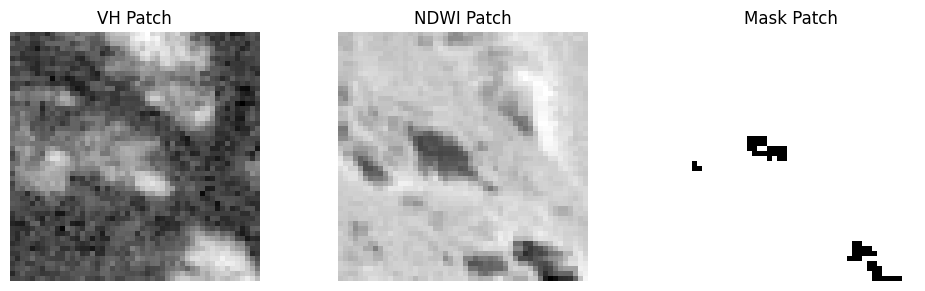


VH Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,0.35,0.31,0.32,0.29,0.25
1,0.27,0.25,0.32,0.32,0.27
2,0.33,0.29,0.29,0.30,0.25
3,0.28,0.28,0.29,0.26,0.24
4,0.31,0.31,0.24,0.27,0.27



NDWI Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,0.65,0.65,0.64,0.66,0.66
1,0.64,0.64,0.65,0.67,0.67
2,0.64,0.64,0.64,0.66,0.68
3,0.65,0.64,0.64,0.66,0.67
4,0.66,0.66,0.65,0.66,0.66



Mask Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,1.00,1.00,1.00,1.00,1.00
1,1.00,1.00,1.00,1.00,1.00
2,1.00,1.00,1.00,1.00,1.00
3,1.00,1.00,1.00,1.00,1.00
4,1.00,1.00,1.00,1.00,1.00


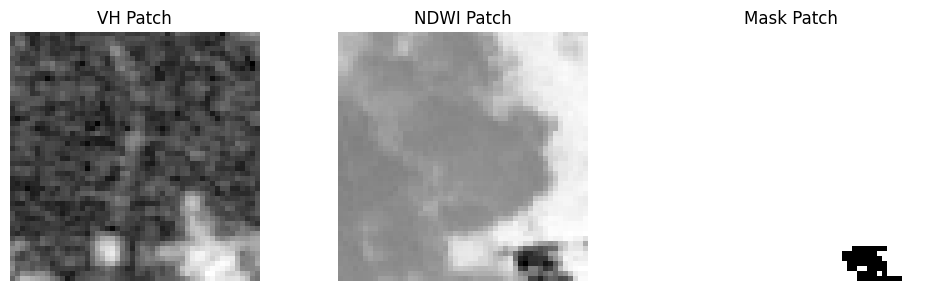


VH Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,0.29,0.30,0.27,0.19,0.18
1,0.24,0.33,0.32,0.25,0.16
2,0.26,0.35,0.37,0.27,0.15
3,0.31,0.29,0.32,0.26,0.22
4,0.32,0.26,0.24,0.23,0.26



NDWI Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,0.66,0.66,0.66,0.65,0.64
1,0.66,0.64,0.64,0.64,0.64
2,0.66,0.64,0.65,0.64,0.63
3,0.66,0.64,0.64,0.64,0.62
4,0.67,0.65,0.65,0.64,0.61



Mask Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,1.00,1.00,1.00,1.00,1.00
1,1.00,1.00,1.00,1.00,1.00
2,1.00,1.00,1.00,1.00,1.00
3,1.00,1.00,1.00,1.00,1.00
4,1.00,1.00,1.00,1.00,1.00


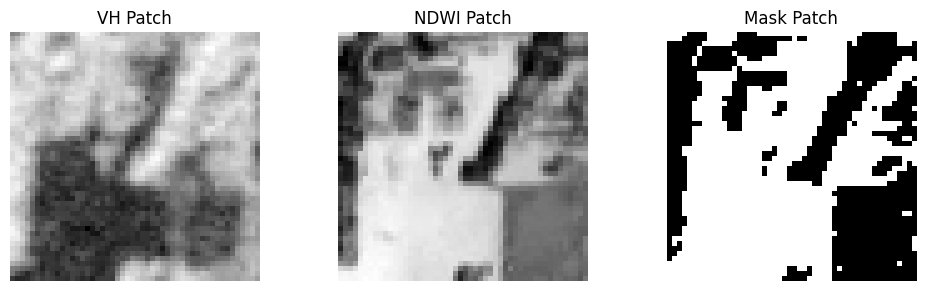


VH Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,0.42,0.45,0.55,0.64,0.71
1,0.51,0.56,0.64,0.68,0.70
2,0.58,0.61,0.68,0.70,0.69
3,0.61,0.63,0.67,0.71,0.70
4,0.66,0.66,0.66,0.69,0.70



NDWI Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,0.83,0.82,0.80,0.60,0.26
1,0.61,0.60,0.58,0.45,0.32
2,0.52,0.38,0.34,0.36,0.39
3,0.43,0.23,0.27,0.34,0.32
4,0.39,0.18,0.25,0.29,0.27



Mask Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,1.00,1.00,1.00,1.00,0.00
1,1.00,1.00,1.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00


X shape: (160, 50, 50, 2)


In [118]:
## Load and visualize data

print("Loading and augmenting patches...")
X_vh, X_ndwi, y = load_and_extract_patches(data_dir)
# Print dimensions
print(f"X_vh shape: {X_vh.shape}")
print(f"X_ndwi shape: {X_ndwi.shape}")
print(f"y shape: {y.shape}")
# show_patch_triplets(X_vh, X_ndwi, y, num_patches=3)
X_vh = (X_vh - X_vh.min()) / (X_vh.max() - X_vh.min())
X_ndwi = (X_ndwi - X_ndwi.min()) / (X_ndwi.max() - X_ndwi.min())
X_vh, X_ndwi, y = augment_dataset(X_vh, X_ndwi, y)
# Print dimensions
print(f"X_vh shape: {X_vh.shape}")
print(f"X_ndwi shape: {X_ndwi.shape}")
print(f"y shape: {y.shape}")
show_patch_triplets(X_vh, X_ndwi, y, num_patches=3)
X = np.concatenate([X_vh, X_ndwi], axis=-1)
print(f"X shape: {X.shape}")


In [119]:
print(X_vh.shape)
print(X_ndwi.shape)
print(y.shape)


(160, 50, 50, 1)
(160, 50, 50, 1)
(160, 50, 50, 1)


In [120]:
X_vh = np.squeeze(X_vh, axis=-1)
X_ndwi = np.squeeze(X_ndwi, axis=-1)
y = np.squeeze(y, axis=-1)

In [121]:
X = np.stack([X_vh, X_ndwi], axis=-1)

In [122]:
X.shape

(160, 50, 50, 2)

In [123]:
y.shape

(160, 50, 50)

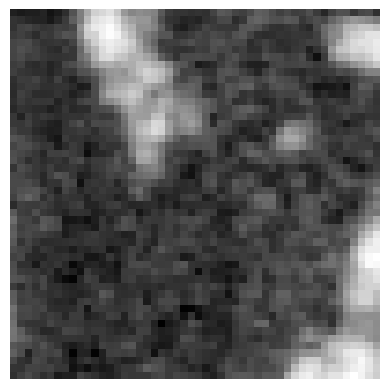

In [124]:
sample_idx = 10
image = X[sample_idx, :, :, 0]
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()


In [125]:
X_flat = X.reshape(-1, X.shape[-1])
y_binary = (y > 0.5).astype(int)
y_flat = y_binary.reshape(-1)


In [126]:
print(np.unique(y_flat))
print(y_flat[:20])


[0 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [128]:
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_flat, y_flat, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42
)
#60% train, 20% val, 20% test


In [129]:
X_train.shape

(240000, 2)

In [130]:
y_train.shape

(240000,)

In [131]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib

class SimpleRandomForestClassifier:
    def __init__(self):
        self.model = Pipeline([
            ('rf', RandomForestClassifier(
                n_estimators=100,
                max_depth=None,
                random_state=42
            ))
        ])

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        joblib.dump(self.model, 'rf.pkl')
        print("model trained and saved as rf.pkl")

rf = SimpleRandomForestClassifier()
rf.train(X_train, y_train)



model trained and saved as rf.pkl


In [132]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [133]:
#compute and log metrics
import numpy as np
import pandas as pd
import time
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, jaccard_score, cohen_kappa_score
)
import os

def compute_metrics(phase, true_labels, predicted_labels):
    flat_true = np.ravel(true_labels)
    flat_pred = np.ravel(predicted_labels)

    return {
        "Timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "Phase": phase,
        "Accuracy": accuracy_score(flat_true, flat_pred),
        "Balanced Accuracy": balanced_accuracy_score(flat_true, flat_pred),
        "Precision": precision_score(flat_true, flat_pred, zero_division=0),
        "Recall": recall_score(flat_true, flat_pred),
        "F1 Score": f1_score(flat_true, flat_pred),
        "IoU": jaccard_score(flat_true, flat_pred),
        "Cohen Kappa": cohen_kappa_score(flat_true, flat_pred),
        "Positive %": round(np.mean(flat_true) * 100, 2),
    }

def evaluate_and_log(y_true, y_pred, csv_path, phase):
    metrics = compute_metrics(phase, y_true, y_pred)
    df = pd.DataFrame([metrics])

    if not os.path.isfile(csv_path):
        df.to_csv(csv_path, index=False)
    else:
        df.to_csv(csv_path, mode='a', header=False, index=False)

    print(f"✅ Metrics logged for {phase} phase.")





In [134]:

train_pred = rf.model.predict(X_train)
val_pred = rf.model.predict(X_val)
test_pred = rf.model.predict(X_test)

train_pred_binary = train_pred
val_pred_binary = val_pred
test_pred_binary = test_pred

train_true_binary = y_train
val_true_binary = y_val
test_true_binary = y_test



In [135]:
evaluate_and_log(y_train, train_pred, results_path, "Train")
evaluate_and_log(y_val, val_pred, results_path, "Validation")
evaluate_and_log(y_test, test_pred, results_path, "Test")

✅ Metrics logged for Train phase.
✅ Metrics logged for Validation phase.
✅ Metrics logged for Test phase.
